# ML-Agents Open a UnityEnvironment
<img src="https://github.com/Unity-Technologies/ml-agents/blob/release_18_docs/docs/images/image-banner.png?raw=true" align="middle" width="435"/>

## Setup

In [2]:
#@title Install Rendering Dependencies { display-mode: "form" }
#@markdown (You only need to run this code when using Colab's hosted runtime)

import os
from IPython.display import HTML, display
import mlagents
import tensorflow as tf 
from tensorflow import keras 
import matplotlib.pyplot as plt
import numpy as np
print(tf.__version__)
physical_devices = tf.config.list_physical_devices(
    device_type=None
)
print(physical_devices)
from mlagents_envs.registry import default_registry


            
#@title Select Environment { display-mode: "form" }
env_id = "3DBall" #@param ['Basic', '3DBall', '3DBallHard', 'GridWorld', 'Hallway', 'VisualHallway', 'CrawlerDynamicTarget', 'CrawlerStaticTarget', 'Bouncer', 'SoccerTwos', 'PushBlock', 'VisualPushBlock', 'WallJump', 'Tennis', 'Reacher', 'Pyramids', 'VisualPyramids', 'Walker', 'FoodCollector', 'VisualFoodCollector', 'StrikersVsGoalie', 'WormStaticTarget', 'WormDynamicTarget']
# -----------------
# This code is used to close an env that might not have been closed before

env = default_registry[env_id].make()
env.reset()
# We will only consider the first Behavior
behavior_name = list(env.behavior_specs)[0]
print(f"Name of the behavior : {behavior_name}")
spec = env.behavior_specs[behavior_name]
env.reset()
decision_steps, terminal_steps = env.get_steps(behavior_name)
num_agents = len(decision_steps.agent_id)
input_dims  = decision_steps.obs[0].shape[1]
n_actions = spec.action_spec.continuous_size


2.8.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2022-02-14 21:02:56.339982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 21:02:56.345404: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-02-14 21:02:56.345418: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found path: /tmp/ml-agents-binaries/binaries/3DBall-b1b94a0ae13eef9d91f9d8db1e5770c5/Startup/Startup.x86_64
Name of the behavior : 3DBall?team=0


In [3]:


class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_ctr = 0 
        self.state_memory = np.zeros((self.mem_size,input_shape))
        self.new_state_memory = np.zeros((self.mem_size,input_shape))
        self.action_memory = np.zeros((self.mem_size,n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size,dtype = np.float32)
        
    def store_transition(self,state,action,reward,next_state,done):
        index = self.mem_ctr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = next_state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_ctr+= 1 
        
    def sample_buffer(self,batch_size):
        max_mem = min(self.mem_ctr,self.mem_size)
        batch = np.random.choice(max_mem, batch_size)
        states = self.state_memory[batch]
        new_states = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        terminal = self.terminal_memory[batch]
        
        return states, actions, rewards, new_states, terminal 


class Actor(tf.keras.Model):
    def __init__(self,n_actions,action_bounds,input_dims):
        super(Actor,self).__init__()
        self.list_layers = []
        self.n_layers = 2
        self.action_bounds = action_bounds
        self.list_layers.append(keras.layers.Input(shape=(input_dims,)))
        for i in range(self.n_layers):
            self.list_layers.append(keras.layers.BatchNormalization())
            self.list_layers.append(tf.keras.layers.Dense(512,\
                                                          activation = 'relu'))
        self.list_layers.append(keras.layers.BatchNormalization())
        self.list_layers.append(keras.layers.Dense(n_actions,activation ='tanh'))
        self.actor = keras.Sequential(self.list_layers)
    def __call__(self,inputs):
        Z = self.actor(inputs)
        #v_min,v_max = 
        #Z = tf.clip_by_value(Z,v_min,v_max)
        return Z 
    
class Critic(tf.keras.Model):
    def __init__(self,input_dims,n_actions,num_layers = 2):
        super(Critic,self).__init__()
        self.list_layers = []
        self.list_layers.append(keras.layers.Input(shape=(input_dims+n_actions,)))
        for i in range(num_layers):
            self.list_layers.append(keras.layers.Dense(512,activation = 'relu'))
        self.list_layers.append(keras.layers.Dense(1))
        self.critic = keras.Sequential(self.list_layers)
    def call(self,state,action):
        Z = self.critic(tf.concat([state,action],axis = 1 ))
        return Z 

# -----------------





class Agent(object):
    
    def __init__(self,memory_size,n_actions,action_bounds,input_dims,optimizers,gamma=0.99):
        self.action_bounds = action_bounds
        self.Actor_local = Actor(n_actions=n_actions,action_bounds= action_bounds,input_dims=input_dims)
        self.Actor_target = Actor(n_actions=n_actions,action_bounds= action_bounds,input_dims=input_dims)
        self.Critic_local = Critic(input_dims,n_actions)
        self.Critic_target = Critic(input_dims,n_actions)
        self.ReplayBuffer = ReplayBuffer(memory_size,input_dims,n_actions)
        self.actor_opt,self.critic_opt = optimizers
        self.Actor_local.compile(loss = 'mse',optimizer = self.actor_opt)
        self.Critic_local.compile(loss = 'mse',optimizer = self.critic_opt)
        #self.h = tf.keras.losses.Huber()
        #self.noise = Noise()
        self.gamma = gamma
        self.noise = 0.005
        
    def remember(self,exp):
        state,action,reward,next_state,done = exp
        self.ReplayBuffer.store_transition(state,action,reward,next_state,done )
    
    def choose_action(self,state,noise=True):
        action = self.Actor_local(state).numpy()
        if noise:
            action+= np.random.normal(0,self.noise,action.shape)
        

        return action
    
    def soft_update(self,eta= 0.00001):
        target_weights_actor = self.Actor_target.get_weights()
        local_weights_actor = self.Actor_local.get_weights()
        target_weights_critic = self.Critic_target.get_weights()
        local_weights_critic = self.Critic_local.get_weights()
        update_weights_actor = []
        update_weights_critic = []
        for i in range(len(target_weights_actor)):
            update_weights_actor.append((1-eta)*target_weights_actor[i]+eta*local_weights_actor[i])
        self.Actor_target.set_weights(update_weights_actor)
        for i in range(len(target_weights_critic)):
            update_weights_critic.append((1-eta)*target_weights_critic[i]+eta*local_weights_critic[i])
        self.Critic_target.set_weights(update_weights_critic)
        
        
    def learn(self,batch_size):
        exp = self.ReplayBuffer. sample_buffer(batch_size)
        states,actions,rewards,next_states,dones = exp 



        
        with tf.GradientTape() as tape_critic:
            next_actions = self.Actor_target(next_states)
            next_critic_values = tf.squeeze(self.Critic_target(next_states,next_actions),1)
            target_values = rewards + self.gamma*(1-dones)*next_critic_values
            critic_values = tf.squeeze(self.Critic_local(states,actions))
            loss_critic = tf.reduce_mean(tf.square(target_values-critic_values))
        gradient_critic = tape_critic.gradient(loss_critic,self.Critic_local.trainable_variables)
        self.critic_opt.apply_gradients(zip(gradient_critic,self.Critic_local.trainable_variables))
        
        with tf.GradientTape() as tape_actor:
            critic_policy_actions = self.Actor_local(states)
            critic_policy_values = self.Critic_local(states,critic_policy_actions)
            actor_loss = -tf.reduce_mean(critic_policy_values)
            
        gradient_actor = tape_actor.gradient(actor_loss, self.Actor_local.trainable_variables)
        self.actor_opt.apply_gradients(zip(gradient_actor,self.Actor_local.trainable_variables))
        
        self.soft_update()

In [4]:
n_actions = 2
memory_size = 250000
action_bounds =(-1,1)
optimizers= (keras.optimizers.Adam(learning_rate=1e-4),keras.optimizers.Adam(learning_rate=1e-4))
batch_size = 32


In [5]:
from mlagents_envs.environment import ActionTuple

In [6]:
agent = Agent(memory_size,n_actions = n_actions,action_bounds = (-2,2),input_dims = input_dims,optimizers = optimizers)

2022-02-14 21:02:59.949715: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
agent.Actor_local.actor = keras.models.load_model('local_actor_3Dball.hf5',compile=True)
agent.Critic_local.critic = keras.models.load_model('local_critic_3Dball.hf5',compile=True)
#agent.Actor_local.actor.compile(loss = 'MSE',optimizer = agent.actor_opt)
#agent.Critic_local.compile(loss = '',optimizer = agent.critic_opt)

In [ ]:
done = False 
history = []
avg_score = 0
n_episodes = 5000
n_episodes_1 = 100



max_avg_score = 0
lr_step = 0
rewards = []
for ep in range(n_episodes):
    flag = True

    env.reset()
    decision_steps, terminal_steps = env.get_steps(behavior_name)

        
    tracked_agent = -1
    score = 0
    done = False
    step =0
    agent.noise = 0.025 if ep <=1000 else 0.001



  
    while (len(decision_steps)!=0) and (step<30000):
        

            
            
        lr_step+=1
        ids = []
        action_tuple = ActionTuple()
        
        last_step = decision_steps
        agent_ids = last_step.agent_id
       
        actions = agent.choose_action(last_step.obs[0])
        action_tuple.add_continuous(actions)
            
        
        env.set_actions(behavior_name, action_tuple)
        env.step()
        
        decision_steps, terminal_steps = env.get_steps(behavior_name)
        
        if len(decision_steps)!=0:
            for ind,val in enumerate(decision_steps.agent_id):
                state = last_step[val].obs[0]
                action =actions[np.where(agent_ids==val)[0][0]]
                next_state = decision_steps[val].obs[0]
                reward = decision_steps[val].reward
                done = False
                exp = state,action,reward,next_state,done
                agent.remember(exp)
                rewards.append(reward)
        


        if len(terminal_steps)!=0:
            for ind,val in enumerate(terminal_steps.agent_id):
                state =last_step[val].obs[0]
                action = actions[np.where(agent_ids==val)[0][0]]
                next_state = terminal_steps[val].obs[0]
                reward = terminal_steps[val].reward

                done = True
                exp = state,action,reward,next_state,done
                agent.remember(exp)
                rewards.append(reward)
              
        agent.learn(batch_size)
        
        score+=np.mean(rewards)
        step+=1 
        
        



            
 
   
    history.append(score)
    avg_score =  np.mean(history[-100:])
    if avg_score >= 100:
        agent.Actor_local.actor.save('local_actor_3Dball.hf5')
        agent.Critic_local.critic.save('local_critic_3Dball.hf5')
        break 
        
    #if (ep>50) & (avg_score>=max_avg_score+10):
    #    max_avg_score = avg_score
    #    agent.Actor_local.actor.save('Actor_LunarLanderContinuous_1.hf5')
    #    agent.Critic_local.critic.save('Critic_LunarLanderContinuous_1.hf5')
        
        
    print('episode :', ep ,'score %.2f average_score %.2f noise :  %.2f '%(score,avg_score,agent.noise))

episode : 0 score 1.59 average_score 1.59 noise :  0.03 
episode : 1 score 1.12 average_score 1.36 noise :  0.03 
episode : 2 score 1.05 average_score 1.26 noise :  0.03 
episode : 3 score 0.86 average_score 1.16 noise :  0.03 
episode : 4 score 1.22 average_score 1.17 noise :  0.03 
episode : 5 score 1.04 average_score 1.15 noise :  0.03 
episode : 6 score 1.14 average_score 1.15 noise :  0.03 
episode : 7 score 1.05 average_score 1.13 noise :  0.03 
episode : 8 score 1.23 average_score 1.15 noise :  0.03 
episode : 9 score 1.24 average_score 1.15 noise :  0.03 
episode : 10 score 0.98 average_score 1.14 noise :  0.03 
episode : 11 score 1.07 average_score 1.13 noise :  0.03 
episode : 12 score 0.98 average_score 1.12 noise :  0.03 
episode : 13 score 0.98 average_score 1.11 noise :  0.03 
episode : 14 score 0.98 average_score 1.10 noise :  0.03 
episode : 15 score 0.98 average_score 1.09 noise :  0.03 
episode : 16 score 1.07 average_score 1.09 noise :  0.03 
episode : 17 score 0.89 

episode : 141 score 0.97 average_score 1.06 noise :  0.03 
episode : 142 score 1.15 average_score 1.06 noise :  0.03 
episode : 143 score 1.23 average_score 1.07 noise :  0.03 
episode : 144 score 1.06 average_score 1.07 noise :  0.03 
episode : 145 score 1.06 average_score 1.07 noise :  0.03 
episode : 146 score 1.06 average_score 1.07 noise :  0.03 
episode : 147 score 1.24 average_score 1.07 noise :  0.03 
episode : 148 score 1.06 average_score 1.07 noise :  0.03 
episode : 149 score 1.06 average_score 1.07 noise :  0.03 
episode : 150 score 1.15 average_score 1.08 noise :  0.03 
episode : 151 score 1.24 average_score 1.08 noise :  0.03 
episode : 152 score 1.06 average_score 1.08 noise :  0.03 
episode : 153 score 1.24 average_score 1.08 noise :  0.03 
episode : 154 score 1.24 average_score 1.09 noise :  0.03 
episode : 155 score 1.15 average_score 1.09 noise :  0.03 
episode : 156 score 1.24 average_score 1.09 noise :  0.03 
episode : 157 score 1.06 average_score 1.09 noise :  0.0

episode : 280 score 1.43 average_score 1.13 noise :  0.03 
episode : 281 score 1.25 average_score 1.13 noise :  0.03 
episode : 282 score 1.16 average_score 1.13 noise :  0.03 
episode : 283 score 1.34 average_score 1.14 noise :  0.03 
episode : 284 score 0.98 average_score 1.13 noise :  0.03 
episode : 285 score 1.25 average_score 1.13 noise :  0.03 
episode : 286 score 1.34 average_score 1.14 noise :  0.03 
episode : 287 score 1.25 average_score 1.14 noise :  0.03 
episode : 288 score 1.25 average_score 1.14 noise :  0.03 
episode : 289 score 1.16 average_score 1.14 noise :  0.03 
episode : 290 score 1.34 average_score 1.14 noise :  0.03 
episode : 291 score 1.16 average_score 1.14 noise :  0.03 
episode : 292 score 1.34 average_score 1.14 noise :  0.03 
episode : 293 score 1.25 average_score 1.14 noise :  0.03 
episode : 294 score 1.07 average_score 1.14 noise :  0.03 
episode : 295 score 0.98 average_score 1.14 noise :  0.03 
episode : 296 score 1.16 average_score 1.14 noise :  0.0

episode : 419 score 0.98 average_score 1.13 noise :  0.03 
episode : 420 score 1.16 average_score 1.13 noise :  0.03 
episode : 421 score 1.07 average_score 1.13 noise :  0.03 
episode : 422 score 1.25 average_score 1.13 noise :  0.03 
episode : 423 score 1.16 average_score 1.13 noise :  0.03 
episode : 424 score 1.16 average_score 1.13 noise :  0.03 
episode : 425 score 1.16 average_score 1.14 noise :  0.03 
episode : 426 score 1.25 average_score 1.14 noise :  0.03 
episode : 427 score 1.07 average_score 1.14 noise :  0.03 
episode : 428 score 1.16 average_score 1.14 noise :  0.03 
episode : 429 score 0.98 average_score 1.13 noise :  0.03 
episode : 430 score 1.07 average_score 1.13 noise :  0.03 
episode : 431 score 1.16 average_score 1.13 noise :  0.03 
episode : 432 score 1.07 average_score 1.14 noise :  0.03 
episode : 433 score 1.16 average_score 1.13 noise :  0.03 
episode : 434 score 1.07 average_score 1.13 noise :  0.03 
episode : 435 score 0.98 average_score 1.13 noise :  0.0

episode : 558 score 1.07 average_score 1.15 noise :  0.03 
episode : 559 score 1.16 average_score 1.15 noise :  0.03 
episode : 560 score 1.07 average_score 1.15 noise :  0.03 
episode : 561 score 0.98 average_score 1.14 noise :  0.03 
episode : 562 score 1.34 average_score 1.15 noise :  0.03 
episode : 563 score 1.25 average_score 1.15 noise :  0.03 
episode : 564 score 1.07 average_score 1.15 noise :  0.03 
episode : 565 score 0.98 average_score 1.15 noise :  0.03 
episode : 566 score 1.25 average_score 1.15 noise :  0.03 
episode : 567 score 1.25 average_score 1.15 noise :  0.03 
episode : 568 score 1.07 average_score 1.15 noise :  0.03 
episode : 569 score 1.25 average_score 1.15 noise :  0.03 
episode : 570 score 1.16 average_score 1.15 noise :  0.03 
episode : 571 score 1.16 average_score 1.15 noise :  0.03 
episode : 572 score 1.25 average_score 1.15 noise :  0.03 
episode : 573 score 0.98 average_score 1.14 noise :  0.03 
episode : 574 score 1.16 average_score 1.14 noise :  0.0

episode : 697 score 1.25 average_score 1.16 noise :  0.03 
episode : 698 score 1.25 average_score 1.16 noise :  0.03 
episode : 699 score 1.25 average_score 1.16 noise :  0.03 
episode : 700 score 1.25 average_score 1.16 noise :  0.03 
episode : 701 score 1.07 average_score 1.16 noise :  0.03 
episode : 702 score 1.16 average_score 1.16 noise :  0.03 
episode : 703 score 1.25 average_score 1.16 noise :  0.03 
episode : 704 score 1.07 average_score 1.16 noise :  0.03 
episode : 705 score 1.07 average_score 1.16 noise :  0.03 
episode : 706 score 1.25 average_score 1.16 noise :  0.03 
episode : 707 score 1.43 average_score 1.16 noise :  0.03 
episode : 708 score 1.16 average_score 1.16 noise :  0.03 
episode : 709 score 1.16 average_score 1.16 noise :  0.03 
episode : 710 score 1.07 average_score 1.16 noise :  0.03 
episode : 711 score 1.25 average_score 1.16 noise :  0.03 
episode : 712 score 1.07 average_score 1.16 noise :  0.03 
episode : 713 score 1.25 average_score 1.16 noise :  0.0

episode : 836 score 1.07 average_score 1.15 noise :  0.03 
episode : 837 score 1.16 average_score 1.15 noise :  0.03 
episode : 838 score 1.07 average_score 1.15 noise :  0.03 
episode : 839 score 1.07 average_score 1.15 noise :  0.03 
episode : 840 score 1.25 average_score 1.15 noise :  0.03 
episode : 841 score 1.34 average_score 1.15 noise :  0.03 
episode : 842 score 1.16 average_score 1.15 noise :  0.03 
episode : 843 score 0.98 average_score 1.15 noise :  0.03 
episode : 844 score 1.07 average_score 1.15 noise :  0.03 
episode : 845 score 1.16 average_score 1.15 noise :  0.03 
episode : 846 score 0.98 average_score 1.15 noise :  0.03 
episode : 847 score 0.98 average_score 1.14 noise :  0.03 
episode : 848 score 1.07 average_score 1.14 noise :  0.03 
episode : 849 score 1.25 average_score 1.14 noise :  0.03 
episode : 850 score 0.98 average_score 1.14 noise :  0.03 
episode : 851 score 0.98 average_score 1.14 noise :  0.03 
episode : 852 score 1.07 average_score 1.14 noise :  0.0

episode : 975 score 1.07 average_score 1.16 noise :  0.03 
episode : 976 score 1.34 average_score 1.16 noise :  0.03 
episode : 977 score 1.25 average_score 1.17 noise :  0.03 
episode : 978 score 1.25 average_score 1.17 noise :  0.03 
episode : 979 score 1.34 average_score 1.17 noise :  0.03 
episode : 980 score 1.25 average_score 1.17 noise :  0.03 
episode : 981 score 1.16 average_score 1.17 noise :  0.03 
episode : 982 score 1.34 average_score 1.17 noise :  0.03 
episode : 983 score 1.34 average_score 1.17 noise :  0.03 
episode : 984 score 1.16 average_score 1.17 noise :  0.03 
episode : 985 score 1.16 average_score 1.17 noise :  0.03 
episode : 986 score 1.07 average_score 1.17 noise :  0.03 
episode : 987 score 1.16 average_score 1.17 noise :  0.03 
episode : 988 score 1.16 average_score 1.17 noise :  0.03 
episode : 989 score 1.25 average_score 1.18 noise :  0.03 
episode : 990 score 1.16 average_score 1.18 noise :  0.03 
episode : 991 score 1.07 average_score 1.18 noise :  0.0

episode : 1112 score 0.98 average_score 1.13 noise :  0.00 
episode : 1113 score 1.16 average_score 1.14 noise :  0.00 
episode : 1114 score 0.98 average_score 1.13 noise :  0.00 
episode : 1115 score 1.16 average_score 1.13 noise :  0.00 
episode : 1116 score 1.16 average_score 1.13 noise :  0.00 
episode : 1117 score 1.25 average_score 1.13 noise :  0.00 
episode : 1118 score 1.07 average_score 1.13 noise :  0.00 
episode : 1119 score 1.25 average_score 1.13 noise :  0.00 
episode : 1120 score 1.43 average_score 1.14 noise :  0.00 
episode : 1121 score 1.16 average_score 1.14 noise :  0.00 
episode : 1122 score 1.07 average_score 1.13 noise :  0.00 
episode : 1123 score 1.07 average_score 1.13 noise :  0.00 
episode : 1124 score 1.07 average_score 1.13 noise :  0.00 
episode : 1125 score 1.16 average_score 1.13 noise :  0.00 
episode : 1126 score 1.07 average_score 1.13 noise :  0.00 
episode : 1127 score 1.16 average_score 1.13 noise :  0.00 
episode : 1128 score 1.07 average_score 

episode : 1249 score 0.98 average_score 1.17 noise :  0.00 
episode : 1250 score 1.25 average_score 1.17 noise :  0.00 
episode : 1251 score 1.16 average_score 1.17 noise :  0.00 
episode : 1252 score 0.98 average_score 1.16 noise :  0.00 
episode : 1253 score 0.98 average_score 1.16 noise :  0.00 
episode : 1254 score 0.98 average_score 1.16 noise :  0.00 
episode : 1255 score 1.07 average_score 1.16 noise :  0.00 
episode : 1256 score 1.16 average_score 1.16 noise :  0.00 
episode : 1257 score 1.25 average_score 1.16 noise :  0.00 
episode : 1258 score 1.16 average_score 1.16 noise :  0.00 
episode : 1259 score 1.34 average_score 1.16 noise :  0.00 
episode : 1260 score 1.25 average_score 1.16 noise :  0.00 
episode : 1261 score 1.25 average_score 1.16 noise :  0.00 
episode : 1262 score 1.16 average_score 1.16 noise :  0.00 
episode : 1263 score 1.43 average_score 1.17 noise :  0.00 
episode : 1264 score 0.98 average_score 1.16 noise :  0.00 
episode : 1265 score 1.07 average_score 

episode : 1386 score 0.98 average_score 1.15 noise :  0.00 
episode : 1387 score 1.16 average_score 1.15 noise :  0.00 
episode : 1388 score 0.98 average_score 1.15 noise :  0.00 
episode : 1389 score 1.25 average_score 1.15 noise :  0.00 
episode : 1390 score 1.16 average_score 1.15 noise :  0.00 
episode : 1391 score 1.07 average_score 1.15 noise :  0.00 
episode : 1392 score 1.34 average_score 1.15 noise :  0.00 
episode : 1393 score 1.16 average_score 1.15 noise :  0.00 
episode : 1394 score 1.16 average_score 1.15 noise :  0.00 
episode : 1395 score 0.98 average_score 1.15 noise :  0.00 
episode : 1396 score 1.07 average_score 1.15 noise :  0.00 
episode : 1397 score 1.07 average_score 1.15 noise :  0.00 
episode : 1398 score 1.16 average_score 1.15 noise :  0.00 
episode : 1399 score 0.98 average_score 1.15 noise :  0.00 
episode : 1400 score 1.25 average_score 1.15 noise :  0.00 
episode : 1401 score 1.16 average_score 1.15 noise :  0.00 
episode : 1402 score 1.07 average_score 

episode : 1523 score 1.07 average_score 1.15 noise :  0.00 
episode : 1524 score 1.16 average_score 1.15 noise :  0.00 
episode : 1525 score 1.43 average_score 1.15 noise :  0.00 
episode : 1526 score 0.98 average_score 1.15 noise :  0.00 
episode : 1527 score 1.34 average_score 1.15 noise :  0.00 
episode : 1528 score 1.16 average_score 1.15 noise :  0.00 
episode : 1529 score 1.07 average_score 1.15 noise :  0.00 
episode : 1530 score 1.25 average_score 1.15 noise :  0.00 
episode : 1531 score 1.07 average_score 1.15 noise :  0.00 
episode : 1532 score 1.07 average_score 1.15 noise :  0.00 
episode : 1533 score 1.16 average_score 1.15 noise :  0.00 
episode : 1534 score 1.16 average_score 1.16 noise :  0.00 
episode : 1535 score 0.98 average_score 1.15 noise :  0.00 
episode : 1536 score 1.16 average_score 1.15 noise :  0.00 
episode : 1537 score 0.98 average_score 1.15 noise :  0.00 
episode : 1538 score 1.07 average_score 1.15 noise :  0.00 
episode : 1539 score 1.16 average_score 

episode : 1660 score 1.25 average_score 1.12 noise :  0.00 
episode : 1661 score 1.25 average_score 1.13 noise :  0.00 
episode : 1662 score 1.07 average_score 1.13 noise :  0.00 
episode : 1663 score 1.25 average_score 1.13 noise :  0.00 
episode : 1664 score 1.34 average_score 1.13 noise :  0.00 
episode : 1665 score 1.16 average_score 1.14 noise :  0.00 
episode : 1666 score 1.16 average_score 1.14 noise :  0.00 
episode : 1667 score 1.07 average_score 1.14 noise :  0.00 
episode : 1668 score 0.98 average_score 1.13 noise :  0.00 
episode : 1669 score 1.07 average_score 1.13 noise :  0.00 
episode : 1670 score 1.16 average_score 1.13 noise :  0.00 
episode : 1671 score 1.25 average_score 1.13 noise :  0.00 
episode : 1672 score 1.07 average_score 1.13 noise :  0.00 
episode : 1673 score 1.07 average_score 1.13 noise :  0.00 
episode : 1674 score 1.07 average_score 1.13 noise :  0.00 
episode : 1675 score 1.16 average_score 1.13 noise :  0.00 
episode : 1676 score 1.07 average_score 

episode : 1797 score 1.07 average_score 1.15 noise :  0.00 
episode : 1798 score 1.25 average_score 1.15 noise :  0.00 
episode : 1799 score 1.34 average_score 1.15 noise :  0.00 
episode : 1800 score 1.25 average_score 1.15 noise :  0.00 
episode : 1801 score 1.16 average_score 1.15 noise :  0.00 
episode : 1802 score 1.16 average_score 1.15 noise :  0.00 
episode : 1803 score 1.16 average_score 1.15 noise :  0.00 
episode : 1804 score 1.34 average_score 1.15 noise :  0.00 
episode : 1805 score 1.25 average_score 1.15 noise :  0.00 
episode : 1806 score 1.07 average_score 1.15 noise :  0.00 
episode : 1807 score 0.89 average_score 1.14 noise :  0.00 
episode : 1808 score 1.25 average_score 1.15 noise :  0.00 
episode : 1809 score 1.25 average_score 1.15 noise :  0.00 
episode : 1810 score 0.98 average_score 1.15 noise :  0.00 
episode : 1811 score 0.98 average_score 1.14 noise :  0.00 
episode : 1812 score 1.25 average_score 1.14 noise :  0.00 
episode : 1813 score 1.16 average_score 

episode : 1934 score 0.98 average_score 1.13 noise :  0.00 
episode : 1935 score 1.25 average_score 1.13 noise :  0.00 
episode : 1936 score 1.16 average_score 1.13 noise :  0.00 
episode : 1937 score 1.07 average_score 1.13 noise :  0.00 
episode : 1938 score 1.25 average_score 1.13 noise :  0.00 
episode : 1939 score 1.16 average_score 1.13 noise :  0.00 
episode : 1940 score 1.07 average_score 1.13 noise :  0.00 
episode : 1941 score 1.25 average_score 1.13 noise :  0.00 
episode : 1942 score 1.16 average_score 1.13 noise :  0.00 
episode : 1943 score 0.98 average_score 1.13 noise :  0.00 
episode : 1944 score 1.25 average_score 1.13 noise :  0.00 
episode : 1945 score 1.25 average_score 1.13 noise :  0.00 
episode : 1946 score 1.16 average_score 1.13 noise :  0.00 
episode : 1947 score 1.16 average_score 1.13 noise :  0.00 
episode : 1948 score 1.16 average_score 1.13 noise :  0.00 
episode : 1949 score 1.07 average_score 1.13 noise :  0.00 
episode : 1950 score 1.34 average_score 

episode : 2071 score 1.16 average_score 1.14 noise :  0.00 
episode : 2072 score 1.16 average_score 1.14 noise :  0.00 
episode : 2073 score 1.16 average_score 1.14 noise :  0.00 
episode : 2074 score 1.16 average_score 1.14 noise :  0.00 
episode : 2075 score 1.07 average_score 1.14 noise :  0.00 
episode : 2076 score 0.98 average_score 1.14 noise :  0.00 
episode : 2077 score 1.07 average_score 1.14 noise :  0.00 
episode : 2078 score 0.89 average_score 1.13 noise :  0.00 
episode : 2079 score 1.07 average_score 1.13 noise :  0.00 
episode : 2080 score 1.16 average_score 1.13 noise :  0.00 
episode : 2081 score 1.16 average_score 1.13 noise :  0.00 
episode : 2082 score 1.25 average_score 1.13 noise :  0.00 
episode : 2083 score 1.16 average_score 1.13 noise :  0.00 
episode : 2084 score 1.16 average_score 1.13 noise :  0.00 
episode : 2085 score 1.07 average_score 1.13 noise :  0.00 
episode : 2086 score 1.16 average_score 1.13 noise :  0.00 
episode : 2087 score 0.98 average_score 

episode : 2208 score 1.34 average_score 1.13 noise :  0.00 
episode : 2209 score 0.98 average_score 1.13 noise :  0.00 
episode : 2210 score 1.34 average_score 1.13 noise :  0.00 
episode : 2211 score 1.07 average_score 1.13 noise :  0.00 
episode : 2212 score 1.25 average_score 1.14 noise :  0.00 
episode : 2213 score 0.98 average_score 1.13 noise :  0.00 
episode : 2214 score 1.25 average_score 1.14 noise :  0.00 
episode : 2215 score 1.25 average_score 1.14 noise :  0.00 
episode : 2216 score 1.07 average_score 1.14 noise :  0.00 
episode : 2217 score 1.25 average_score 1.14 noise :  0.00 
episode : 2218 score 1.16 average_score 1.14 noise :  0.00 
episode : 2219 score 1.16 average_score 1.14 noise :  0.00 
episode : 2220 score 1.07 average_score 1.14 noise :  0.00 
episode : 2221 score 1.16 average_score 1.14 noise :  0.00 
episode : 2222 score 1.07 average_score 1.14 noise :  0.00 
episode : 2223 score 0.98 average_score 1.14 noise :  0.00 
episode : 2224 score 1.25 average_score 

episode : 2345 score 1.25 average_score 1.09 noise :  0.00 
episode : 2346 score 1.16 average_score 1.09 noise :  0.00 
episode : 2347 score 1.16 average_score 1.09 noise :  0.00 
episode : 2348 score 1.07 average_score 1.10 noise :  0.00 
episode : 2349 score 1.16 average_score 1.10 noise :  0.00 
episode : 2350 score 0.89 average_score 1.09 noise :  0.00 
episode : 2351 score 1.25 average_score 1.09 noise :  0.00 
episode : 2352 score 1.25 average_score 1.10 noise :  0.00 
episode : 2353 score 0.98 average_score 1.09 noise :  0.00 
episode : 2354 score 0.89 average_score 1.09 noise :  0.00 
episode : 2355 score 1.34 average_score 1.09 noise :  0.00 
episode : 2356 score 0.98 average_score 1.09 noise :  0.00 
episode : 2357 score 1.16 average_score 1.09 noise :  0.00 
episode : 2358 score 1.25 average_score 1.10 noise :  0.00 
episode : 2359 score 1.16 average_score 1.10 noise :  0.00 
episode : 2360 score 1.25 average_score 1.10 noise :  0.00 
episode : 2361 score 1.07 average_score 

episode : 2482 score 1.25 average_score 1.13 noise :  0.00 
episode : 2483 score 0.98 average_score 1.13 noise :  0.00 
episode : 2484 score 1.25 average_score 1.13 noise :  0.00 
episode : 2485 score 1.16 average_score 1.13 noise :  0.00 
episode : 2486 score 0.98 average_score 1.13 noise :  0.00 
episode : 2487 score 1.07 average_score 1.13 noise :  0.00 
episode : 2488 score 1.16 average_score 1.13 noise :  0.00 
episode : 2489 score 1.07 average_score 1.13 noise :  0.00 
episode : 2490 score 1.25 average_score 1.13 noise :  0.00 
episode : 2491 score 1.07 average_score 1.13 noise :  0.00 
episode : 2492 score 0.98 average_score 1.13 noise :  0.00 
episode : 2493 score 1.16 average_score 1.13 noise :  0.00 
episode : 2494 score 1.25 average_score 1.13 noise :  0.00 
episode : 2495 score 1.25 average_score 1.13 noise :  0.00 
episode : 2496 score 1.16 average_score 1.14 noise :  0.00 
episode : 2497 score 1.16 average_score 1.13 noise :  0.00 
episode : 2498 score 1.16 average_score 

episode : 2619 score 1.16 average_score 1.11 noise :  0.00 
episode : 2620 score 1.16 average_score 1.11 noise :  0.00 


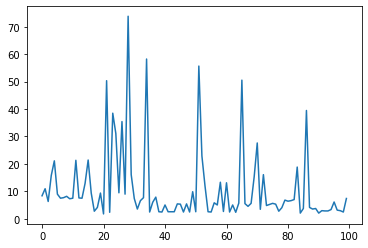

In [8]:
plt.plot(history[-100:])

2022-02-13 23:05:47.744846: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: local_actor_3Dball.hf5/assets


INFO:tensorflow:Assets written to: local_critic_3Dball.hf5/assets


In [9]:
for episode in range(100):
    env.reset()
    decision_steps, terminal_steps = env.get_steps(behavior_name)
    tracked_agent = -1 # -1 indicates not yet tracking
    done = False # For the tracked_agent
    episode_rewards = 0 # For the tracked_agent
    while not done:
    # Track the first agent we see if not tracking
    # Note : len(decision_steps) = [number of agents that requested a decision]
        if tracked_agent == -1 and len(decision_steps) >= 1:
            tracked_agent = decision_steps.agent_id[0]

    # Generate an action for all agents
        actions = agent.choose_action(last_step.obs[0])
        action_tuple.add_continuous(actions)


    # Set the actions
        env.set_actions(behavior_name, action_tuple)

    # Move the simulation forward
        env.step()

    # Get the new simulation results
        decision_steps, terminal_steps = env.get_steps(behavior_name)
        if tracked_agent in decision_steps: # The agent requested a decision
            episode_rewards += decision_steps[tracked_agent].reward
        if tracked_agent in terminal_steps: # The agent terminated its episode
            episode_rewards += terminal_steps[tracked_agent].reward
            done = True
        print(f"Total rewards for episode {episode} is {episode_rewards}")


Total rewards for episode 0 is 0.10000000149011612
Total rewards for episode 0 is 0.20000000298023224
Total rewards for episode 0 is 0.30000000447034836
Total rewards for episode 0 is 0.4000000059604645
Total rewards for episode 0 is 0.5000000074505806
Total rewards for episode 0 is 0.6000000089406967
Total rewards for episode 0 is 0.7000000104308128
Total rewards for episode 0 is 0.800000011920929
Total rewards for episode 0 is 0.9000000134110451
Total rewards for episode 0 is 1.0000000149011612
Total rewards for episode 0 is 1.1000000163912773
Total rewards for episode 0 is 1.2000000178813934
Total rewards for episode 0 is 1.3000000193715096
Total rewards for episode 0 is 0.30000001937150955
Total rewards for episode 1 is 0.10000000149011612
Total rewards for episode 1 is 0.20000000298023224
Total rewards for episode 1 is 0.30000000447034836
Total rewards for episode 1 is 0.4000000059604645
Total rewards for episode 1 is 0.5000000074505806
Total rewards for episode 1 is 0.60000000894

UnityActionException: The behavior 3DBall?team=0 needs a continuous input of dimension (0, 2) for (<number of agents>, <action size>) but received input of dimension (12, 2)

In [352]:
terminal_steps.__dict__

{'obs': [array([[-0.21293847,  0.07868058, -2.6763506 ,  0.57261896,  3.0095015 ,
          -1.8245436 , -6.440617  ,  1.9814156 ]], dtype=float32)],
 'reward': array([-1.], dtype=float32),
 'interrupted': array([False]),
 'agent_id': array([0], dtype=int32),
 'group_id': [0],
 'group_reward': array([0.], dtype=float32),
 '_agent_id_to_index': {0: 0}}

#### Get the Action Space from the Behavior Specs

In [7]:
# Is the Action continuous or multi-discrete ?
if spec.action_spec.continuous_size > 0:
    print(f"There are {spec.action_spec.continuous_size} continuous actions")
if spec.action_spec.is_discrete():
    print(f"There are {spec.action_spec.discrete_size} discrete actions")





There are 2 continuous actions


### Stepping the environment

#### Get the steps from the Environment
You can do this with the `env.get_steps(behavior_name)` method. If there are multiple behaviors in the Environment, you can call this method with each of the behavior's names.
_Note_ This will not move the simulation forward.

In [24]:
env.reset()
decision_steps, terminal_steps = env.get_steps(behavior_name)

In [30]:
decision_steps.obs[0]

(array([[-4.58385758e-02, -2.70688180e-02, -1.43874550e+00,
          3.99607611e+00,  9.79341984e-01,  0.00000000e+00,
         -1.96199998e-01,  0.00000000e+00],
        [ 7.30369315e-02, -7.14064389e-02, -9.66649055e-01,
          3.99607611e+00,  1.29474640e-01,  0.00000000e+00,
         -1.96199998e-01,  0.00000000e+00],
        [ 4.42208499e-02, -7.51109868e-02,  1.27105904e+00,
          3.99607563e+00,  9.11190510e-01,  0.00000000e+00,
         -1.96199998e-01,  0.00000000e+00],
        [ 4.76103649e-02,  2.27974961e-03,  1.14177227e+00,
          3.99607611e+00,  3.54968071e-01,  0.00000000e+00,
         -1.96199998e-01,  0.00000000e+00],
        [ 5.12608923e-02,  2.75232233e-02, -6.70847893e-01,
          3.99607563e+00,  1.00081205e+00,  0.00000000e+00,
         -1.96199998e-01,  0.00000000e+00],
        [-4.58375644e-03,  1.59135635e-03,  1.07326746e-01,
          3.99607563e+00, -1.20461130e+00,  0.00000000e+00,
         -1.96199998e-01,  0.00000000e+00],
        [-1.1298

#### Set actions for each behavior
You can set the actions for the Agents of a Behavior by calling `env.set_actions()` you will need to specify the behavior name and pass a tensor of dimension 2. The first dimension of the action must be equal to the number of Agents that requested a decision during the step.

In [31]:
env.set_actions(behavior_name, spec.action_spec.empty_action(len(decision_steps)))

#### Move the simulation forward
Call `env.step()` to move the simulation forward. The simulation will progress until an Agent requestes a decision or terminates.

In [32]:
env.step()

In [34]:
decision_steps, terminal_steps = env.get_steps(behavior_name)

In [37]:
decision_steps.obs[0]

array([[-4.58385758e-02, -2.70688180e-02, -1.43874550e+00,
         3.91759610e+00,  9.79341984e-01,  0.00000000e+00,
        -1.17719996e+00,  0.00000000e+00],
       [ 7.30369315e-02, -7.14064389e-02, -9.66649055e-01,
         3.91759610e+00,  1.29474640e-01,  0.00000000e+00,
        -1.17719996e+00,  0.00000000e+00],
       [ 4.42208499e-02, -7.51109868e-02,  1.27105904e+00,
         3.91759586e+00,  9.11190510e-01,  0.00000000e+00,
        -1.17719996e+00,  0.00000000e+00],
       [ 4.76103649e-02,  2.27974961e-03,  1.14177227e+00,
         3.91759634e+00,  3.54968071e-01,  0.00000000e+00,
        -1.17719996e+00,  0.00000000e+00],
       [ 5.12608923e-02,  2.75232233e-02, -6.70847893e-01,
         3.91759586e+00,  1.00081205e+00,  0.00000000e+00,
        -1.17719996e+00,  0.00000000e+00],
       [-4.58375644e-03,  1.59135635e-03,  1.07326746e-01,
         3.91759586e+00, -1.20461130e+00,  0.00000000e+00,
        -1.17719996e+00,  0.00000000e+00],
       [-1.12987794e-02, -2.171101

### Observations

#### Show the observations for one of the Agents
`DecisionSteps.obs` is a tuple containing all of the observations for all of the Agents with the provided Behavior name.
Each value in the tuple is an observation tensor containing the observation data for all of the agents.

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

for index, obs_spec in enumerate(spec.observation_specs):
    if len(obs_spec.shape) == 3:
        print("Here is the first visual observation")
        plt.imshow(decision_steps.obs[index][0,:,:,:])
        plt.show()

for index, obs_spec in enumerate(spec.observation_specs):
    if len(obs_spec.shape) == 1:
        print("First vector observations : ", decision_steps.obs[index][0,:])

First vector observations :  [-0.01467304 -0.01468306 -0.5208206   4.         -0.79952097  0.
  0.          0.        ]


### Run the Environment for a few episodes

In [40]:
for episode in range(3):
    env.reset()
    decision_steps, terminal_steps = env.get_steps(behavior_name)
    tracked_agent = -1 # -1 indicates not yet tracking
    done = False # For the tracked_agent
    episode_rewards = 0 # For the tracked_agent
    while not done:
    # Track the first agent we see if not tracking
    # Note : len(decision_steps) = [number of agents that requested a decision]
        if tracked_agent == -1 and len(decision_steps) >= 1:
            tracked_agent = decision_steps.agent_id[0]

    # Generate an action for all agents
        action = spec.action_spec.random_action(len(decision_steps))
        print(len(decision_steps))

    # Set the actions
        env.set_actions(behavior_name, action)

    # Move the simulation forward
        env.step()

    # Get the new simulation results
        decision_steps, terminal_steps = env.get_steps(behavior_name)
        if tracked_agent in decision_steps: # The agent requested a decision
            episode_rewards += decision_steps[tracked_agent].reward
        if tracked_agent in terminal_steps: # The agent terminated its episode
            episode_rewards += terminal_steps[tracked_agent].reward
            done = True
        print(f"Total rewards for episode {episode} is {episode_rewards}")


12
Total rewards for episode 0 is 0.10000000149011612
12
Total rewards for episode 0 is 0.20000000298023224
12
Total rewards for episode 0 is 0.30000000447034836
12
Total rewards for episode 0 is 0.4000000059604645
12
Total rewards for episode 0 is 0.5000000074505806
12
Total rewards for episode 0 is 0.6000000089406967
12
Total rewards for episode 0 is 0.7000000104308128
12
Total rewards for episode 0 is 0.800000011920929
12
Total rewards for episode 0 is 0.9000000134110451
12
Total rewards for episode 0 is 1.0000000149011612
12
Total rewards for episode 0 is 1.1000000163912773
12
Total rewards for episode 0 is 1.2000000178813934
12
Total rewards for episode 0 is 1.3000000193715096
12
Total rewards for episode 0 is 1.4000000208616257
12
Total rewards for episode 0 is 1.5000000223517418
12
Total rewards for episode 0 is 1.5000000223517418
0
Total rewards for episode 0 is 1.600000023841858
12
Total rewards for episode 0 is 1.600000023841858
0
Total rewards for episode 0 is 1.600000023841

### Close the Environment to free the port it is using

In [21]:
env.close()
print("Closed environment")

Closed environment
